<a href="https://colab.research.google.com/github/AnnaBujniewicz/semester_project/blob/main/ml_models_for_stock_data_and_titles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial steps

In [1]:
# importing the needed packages
!pip install transformers &> /dev/null
!pip install yfinance &> /dev/null
!pip install bert-for-tf2 &> /dev/null
import bert
import os
import tensorflow_hub as hub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
import gensim
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from datetime import datetime
nltk.download('wordnet')
warnings.filterwarnings('ignore')
from collections import Counter
import itertools
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from keras import backend as K
from transformers import BertTokenizer
import torch
import re
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1 Preparing data for the models

## 1.1 Cleaning and exploring the sentiment analysis dataset

In [2]:
# loading in the dataframe for sentiment analysis
sent_df = pd.read_csv("https://raw.githubusercontent.com/AnnaBujniewicz/semester_project/main/data/sentiment_data.csv", header = 0, names = ["sentiment", "title"], encoding = "latin-1")

In [3]:
# inspecting the dataframe
sent_df.head()

,sentiment,title
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


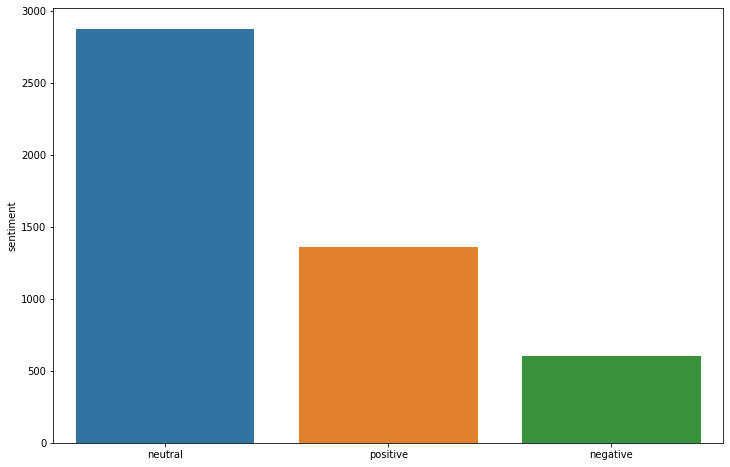

In [4]:
# inspecting the classes
# they are rather unbalanced
plt.figure(figsize=(12,8))
sns.barplot(x=pd.DataFrame(sent_df["sentiment"].value_counts()).index,y=pd.DataFrame(sent_df["sentiment"].value_counts())["sentiment"])
plt.show()

As can be seen, the number of negative and positive headers is vastly lower than the neutral ones. For this reason resampling should be considered. We decided to not try upsampling, as it would have to result in copying the same header multiple times for the case of the negative class. That could really easily lead to some overfitting to the preexisting titles. Instead, we decided to try downsampling. It will lead to a decrease in sample size, however all the titles will still be unique.

In [5]:
# initiating a lemmatizer instance
lemmatizer = WordNetLemmatizer()
# making a list of stopwords
stop_words = set(stopwords.words('english'))
# making a function that lemmatizes the titles and then puts them together
def sneaky_cleanup(title):
# empty list to store the tokens
  tokens = []
# iteration over the words in a given title
  for token in title.split():
# removing the stop words
    if token not in stop_words:
# removing the interpunction
      if token.isalnum():
# appending the lemmatized titles to the list
        tokens.append(lemmatizer.lemmatize(token))
# rejoining the list of words back into a title
  return " ".join(tokens)

In [6]:
# applying the lemmatizer to each row of the dataframe
sent_df.title = sent_df.title.apply(lambda x: sneaky_cleanup(x))
# checking if everything worked correctly
sent_df.head()

,sentiment,title
0,neutral,Technopolis plan develop stage area le square ...
1,negative,The international electronic industry company ...
2,positive,With new production plant company would increa...
3,positive,According company updated strategy year Baswar...
4,positive,FINANCING OF ASPOCOMP GROWTH Aspocomp aggressi...


We decided that cleaning up the text before applying a machine learning model would be beneficial. We lemmatized the words, removed the stopwords and interpunctions.

We chose lemmatization over stemming as it preserves the original meaning of a word better - lemmatiztion changes the word to its lemma (base of the word), whereas stemming simply cuts off the ending.

The stopwords and interpunctions were removed despite their potential importance for the context, as they typically don't improve performance in the case of sentiment analysis, as the model only needs to classify the titles into the category of positive, negative and neutral ones.


In [7]:
# creating three new dataframes for the three sentiments
sent_pos=sent_df[sent_df["sentiment"] == "positive"]
sent_neg=sent_df[sent_df["sentiment"] == "negative"]
sent_neu=sent_df[sent_df["sentiment"] == "neutral"]
# tokenizing the titles in the dataframes
sent_pos["title"]=sent_pos["title"].apply(lambda x: word_tokenize(x))
sent_neg["title"]=sent_neg["title"].apply(lambda x: word_tokenize(x))
sent_neu["title"]=sent_neu["title"].apply(lambda x: word_tokenize(x))

In [8]:
# finding the most popular words in the negative titles
Counter(itertools.chain(*sent_neg["title"])).most_common(10)

[('EUR', 307),
 ('mn', 224),
 ('profit', 151),
 ('The', 105),
 ('company', 104),
 ('Finnish', 99),
 ('sale', 96),
 ('period', 89),
 ('net', 88),
 ('2009', 85)]

In [9]:
# finding the most popular words in the neutral titles
Counter(itertools.chain(*sent_neu["title"])).most_common(10)

[('The', 969),
 ('company', 553),
 ('share', 293),
 ('said', 237),
 ('Finland', 219),
 ('EUR', 217),
 ('Finnish', 215),
 ('million', 192),
 ('service', 189),
 ('sale', 187)]

In [10]:
# finding the most popular words in the positive titles
Counter(itertools.chain(*sent_pos["title"])).most_common(10)

[('EUR', 394),
 ('The', 280),
 ('company', 262),
 ('mn', 241),
 ('said', 230),
 ('Finnish', 198),
 ('sale', 187),
 ('profit', 183),
 ('net', 175),
 ('million', 171)]

As can be seen, the words in all the titles are very similar, showing how difficult the task of predicting the sentiment will be.

In [11]:
# inspecting the length of the titles - the longest title is just above 40 words
sent_df["words"] = sent_df["title"].map(lambda x: len(x.split()))
sent_df["words"].describe()

count    4845.000000
mean       12.831373
std         5.831930
min         1.000000
25%         8.000000
50%        12.000000
75%        16.000000
max        42.000000
Name: words, dtype: float64

In [12]:
# creating a series of all the sentiments
y = sent_df["sentiment"]
# creating a labelencoder instance
labelencoder_y = LabelEncoder()
# encoding the sentiments
y = labelencoder_y.fit_transform(y)
# changing the sentiments to one-hot encoding
y = np_utils.to_categorical(y)

In [13]:
# creating training and testing samples
X_train, X_test, y_train, y_test = train_test_split(sent_df["title"], y, test_size = 0.2, random_state = 44)
X_test_initial = X_test

## 1.2 Preparing the dataset for transformers use and creating transformers layer

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [15]:
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [16]:
# Specify `MAX_LEN`
MAX_LEN = 40

# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [17]:
train_ids = torch.tensor(X_train.index.tolist())
test_ids = torch.tensor(X_test.index.tolist())

In [18]:
train_inputs = train_inputs.numpy().astype("int32")
train_masks = train_masks.numpy().astype("int32")
train_ids = train_ids.numpy().astype("int32")
val_inputs = val_inputs.numpy().astype("int32")
val_masks = val_masks.numpy().astype("int32")
test_ids = test_ids.numpy().astype("int32")

In [19]:
X_train_dic = {"input_word_ids":train_inputs,"input_mask":train_masks,"input_type_ids":train_ids}
X_test_dic = {"input_word_ids":val_inputs,"input_mask":val_masks,"input_type_ids":test_ids}

In [20]:
bert_v2 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", trainable=True, output_key="pooled_output")

INFO:absl:resolver HttpCompressedFileResolver does not support the provided handle.
INFO:absl:resolver GcsCompressedFileResolver does not support the provided handle.


## 1.3 Creating the sentiment analysis model

In [21]:
model = Sequential()
model.add(bert_v2)
model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dense(264, activation = "relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dense(3, activation='softmax'))

In [22]:
# defining early stopping - lower patience this time, more periods weren't needed
# changing the learning rate to a much lower rate
# it makes the results vastly more stable
opt = optimizers.Adam(learning_rate=0.0001)

In [23]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [24]:
perc_neu = sent_df[sent_df["sentiment"]=="neutral"]["sentiment"].count()/sent_df["sentiment"].count()
perc_pos = sent_df[sent_df["sentiment"]=="positive"]["sentiment"].count()/sent_df["sentiment"].count()
perc_neg = sent_df[sent_df["sentiment"]=="negative"]["sentiment"].count()/sent_df["sentiment"].count()

In [25]:
weights = np.array([2,1,2-perc_pos])

In [26]:
# compiling the model with categorical crossentropy as a loss function
# it was chosen as it is an appropriate measure for multiclass predictions
model.compile(optimizer = opt, loss=weighted_categorical_crossentropy(weights), metrics=['accuracy'])

In [27]:
# fitting the model to the original data
# batch size chosen for the best results
# here the results are not amazing, but much better than for the downsampled data
history = model.fit(X_train_dic, y_train, batch_size=64, epochs = 10)

Epoch 1/10
Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


61/61 [==============================] - 43s 490ms/step - loss: 1.3857 - accuracy: 0.5488
Epoch 2/10
61/61 [==============================] - 31s 501ms/step - loss: 1.0881 - accuracy: 0.6946
Epoch 3/10
61/61 [==============================] - 31s 511ms/step - loss: 0.7674 - accuracy: 0.8003
Epoch 4/10
61/61 [==============================] - 32s 518ms/step - loss: 0.4464 - accuracy: 0.8828
Epoch 5/10
61/61 [==============================] - 32s 526ms/step - loss: 0.3842 - accuracy: 0.9131
Epoch 6/10
61/61 [==============================] - 32s 527ms/step - loss: 0.2278 - accuracy: 0.9439
Epoch 7/10
61/61 [==============================] - 32s 533ms/step - loss: 0.1783 - accuracy: 0.9604
Epoch 8/10
61/61 [==============================] - 33s 537ms/step - loss: 0.1960 - accuracy: 0.9541
Epoch 9/10
61/61 [==============================] - 33s 541ms/step - loss: 0.1241 - accuracy: 0.9757
Epoch 10/10
61/61 [==============================] - 33s 545ms/step - loss: 0.1129 - accuracy: 0.9749


## 1.4 Evaluation of the sentiment model

In [28]:
# evaluating the accuracy on the test set - it is not amazing
model.evaluate(X_test_dic, y_test)

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


31/31 [==============================] - 4s 95ms/step - loss: 1.5621 - accuracy: 0.7822


[1.5621421337127686, 0.7822497487068176]

In [29]:
# finding the predictions
y_pred = model.predict(X_test_dic)
# creating a numpy array filled with zeroes
y_pred_hardmax = np.zeros_like(y_pred)
# assigning one to the class with the highest outcome
y_pred_hardmax[np.arange(len(y_pred)), y_pred.argmax(1)] = 1

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


In [30]:
# changing back from one hot encoding to a list of classes
y_pred_hardmax= [np.argmax(y, axis=None, out=None) for y in y_pred_hardmax]
y_test= [np.argmax(y, axis=None, out=None) for y in y_test]

In [31]:
# reversing the encoding
y_test = labelencoder_y.inverse_transform(y_test)
y_pred_hardmax = labelencoder_y.inverse_transform(y_pred_hardmax)

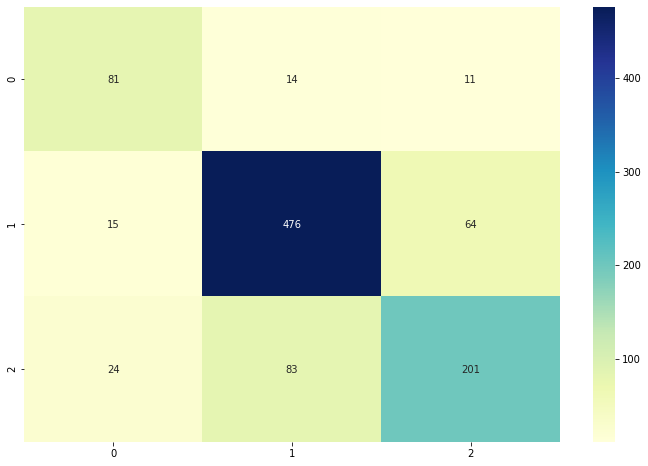

In [32]:
# creating a confusion matrix 
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_pred_hardmax,y_test), annot = True, cmap = "YlGnBu",fmt='g')

In [33]:
# printing out the classification report
print(classification_report(y_pred_hardmax,y_test))

              precision    recall  f1-score   support

    negative       0.68      0.76      0.72       106
     neutral       0.83      0.86      0.84       555
    positive       0.73      0.65      0.69       308

    accuracy                           0.78       969
   macro avg       0.74      0.76      0.75       969
weighted avg       0.78      0.78      0.78       969



In [34]:
# creating a dataframe from X_test
X_test_initial = pd.DataFrame(X_test_initial)
# resetting the index
X_test_initial = X_test_initial.reset_index()
# only keeping the title column
X_test_initial = X_test_initial.loc[:,"title"]
# turning it into a dataframe again
X_test_initial = pd.DataFrame(X_test_initial)

In [35]:
# creating a dataframe from y_test
y_test = pd.DataFrame(y_test)
# creating a dataframe from the label predictions
y_pred_hardmax = pd.DataFrame(y_pred_hardmax)
# adding the new columns to X_test_initial
X_test_initial["y"] = y_test
X_test_initial["pred"] = y_pred_hardmax
# turning the softmax predictions into a dataframe
y_pred = pd.DataFrame(y_pred)
# merging the dataframes
X_test_initial = X_test_initial.merge(y_pred, left_index = True, right_index=True,copy = False)
X_test_initial.describe()

,0,1,2
count,969.000000,969.000000,969.000000
mean,0.109133,0.572375,0.318490
std,0.291206,0.471568,0.440366
min,0.000058,0.000725,0.002082
25%,0.000068,0.008915,0.002332
50%,0.000392,0.986147,0.004962
75%,0.001384,0.997602,0.969107
max,0.982210,0.997857,0.998395


## 1.5 Sentiment analysis for articles for the chosen companies

In [36]:
#INSERT THE NEW ARTICLES HERE
alxn_art = pd.read_csv("https://raw.githubusercontent.com/AnnaBujniewicz/semester_project/main/data/proc_alxn_data.csv")
alxn_art.head()

,Unnamed: 0,1,link,title
0,1,2020-12-23,https://t.co/v7UATxnMUy,"CVS & Walgreens Hiring 35,000 To Help With Vac..."
1,5,2020-12-22,https://t.co/wMy1spFJMS,StockCharts.com
2,7,2020-12-22,https://t.co/cCk00oo4ZF,Are you a robot?
3,8,2020-12-22,https://t.co/AqJYWoUC0J,FDA approves Pfizer's Covid vaccine for emerge...
4,9,2020-12-22,https://t.co/22qlhrlW30,Stock Market Insights


In [37]:
alxn_art.rename(columns = {'1':'date'}, inplace = True)
# only keeping the relevant columns
alxn_art = alxn_art.loc[:,["title","date"]]
alxn_art["title"] = alxn_art["title"].astype(str)
# applying the cleanup function to each row of the dataframe
alxn_art.title = alxn_art.title.apply(lambda x: sneaky_cleanup(x))
# turning the date column to datetime format
alxn_art["date"] = pd.to_datetime(alxn_art["date"], format='%Y-%m-%d', errors='coerce')
# dropping the duplicated dates - we only want one article per day
alxn_art = alxn_art.drop_duplicates(subset = "title")
#dropping the titles with 5 words or less - they likely aren't titles at all
alxn_art = alxn_art[alxn_art['title'].str.split().str.len().ge(5)]
alxn_art.reset_index(inplace=True)
# inspecting the changes
alxn_art.head()

,index,title,date
0,0,CVS Walgreens Hiring To Help With Vaccine Dist...,2020-12-23
1,3,FDA approves Covid vaccine emergency use reach...,2020-12-22
2,7,Should Investors Consider This Biotech Takeover,2020-12-22
3,12,Daniel Bazarko Net worth insider trading,2020-12-21
4,13,3 Biotech Stocks That Could Explode Higher 2021,2020-12-21


In [38]:
alxn_art["date"].value_counts().describe()

count    440.000000
mean       2.481818
std        3.540155
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       60.000000
Name: date, dtype: float64

In [39]:
alxn_titles = alxn_art.title
alxn_inputs, alxn_masks = preprocessing_for_bert(alxn_titles)
alxn_ids = torch.tensor(alxn_titles.index.tolist())
alxn_inputs = alxn_inputs.numpy().astype("int32")
alxn_masks = alxn_masks.numpy().astype("int32")
alxn_ids = alxn_ids.numpy().astype("int32")
alxn_dic = {"input_word_ids":alxn_inputs,"input_mask":alxn_masks,"input_type_ids":alxn_ids}

In [40]:
# predicting the headings
alxn_preds = model.predict(alxn_dic)
alxn_preds

array([[6.2780993e-05, 9.9761707e-01, 2.3201564e-03],
       [4.3852747e-04, 2.1178782e-02, 9.7838265e-01],
       [1.3047011e-04, 9.9666864e-01, 3.2009014e-03],
       ...,
       [4.0913469e-04, 2.2529315e-03, 9.9733788e-01],
       [1.4849105e-04, 9.9493486e-01, 4.9166698e-03],
       [7.2561394e-05, 9.9749005e-01, 2.4374498e-03]], dtype=float32)

In [41]:
# turning the predictions into a dataframe
alxn_preds = pd.DataFrame(alxn_preds)
# merging the articles and predictions dataframe
alxn_sent = alxn_art.merge(alxn_preds, left_index = True, right_index=True)
alxn_sent.head()

,index,title,date,0,1,2
0,0,CVS Walgreens Hiring To Help With Vaccine Dist...,2020-12-23,0.000063,0.997617,0.002320
1,3,FDA approves Covid vaccine emergency use reach...,2020-12-22,0.000439,0.021179,0.978383
2,7,Should Investors Consider This Biotech Takeover,2020-12-22,0.000130,0.996669,0.003201
3,12,Daniel Bazarko Net worth insider trading,2020-12-21,0.000064,0.997796,0.002141
4,13,3 Biotech Stocks That Could Explode Higher 2021,2020-12-21,0.001398,0.959625,0.038977


In [42]:
# checking the variability of the class columns
# the differences between the values seem to be high enough
alxn_sent.describe()

,index,0,1,2
count,1092.000000,1092.000000,1092.000000,1092.000000
mean,3158.169414,0.044014,0.727897,0.228088
std,2185.939209,0.187985,0.415086,0.390551
min,0.000000,0.000057,0.000720,0.002058
25%,1230.750000,0.000069,0.320433,0.002330
50%,2870.000000,0.000131,0.996543,0.003339
75%,5149.750000,0.000762,0.997605,0.246552
max,7097.000000,0.979052,0.997879,0.998380


In [43]:
alxn_sent = alxn_sent.groupby(["date"]).mean()
alxn_sent.rename(columns = {0:'negative',1:'neutral',2:'positive'}, inplace = True)
alxn_sent = alxn_sent.loc[:,["negative","neutral","positive"]]
alxn_sent.head()

,negative,neutral,positive
date,,,
2019-01-03,0.000179,0.748008,0.251813
2019-01-05,0.000681,0.973831,0.025488
2019-01-06,0.000074,0.997519,0.002407
2019-01-07,0.000083,0.997097,0.002820
2019-01-08,0.000087,0.997104,0.002809


## 1.6 Building an embedding layer

In [44]:
articles = pd.read_csv("https://github.com/AnnaBujniewicz/semester_project/blob/main/data/raw_partner_headlines.csv.zip?raw=true", compression = "zip")

In [45]:
articles_for_embed = pd.DataFrame(articles.loc[:,"headline"])
sent_df_for_embed = pd.DataFrame(sent_df["title"])
embed = pd.concat([sent_df_for_embed,articles_for_embed], ignore_index = True)
embed["title"].fillna(embed["headline"], inplace = True)
embed = embed.loc[:,["title"]]
embed1 = embed[:int(len(embed)/3)]
embed2 = embed[int(len(embed)/3):int(len(embed)*(2/3))].reset_index()
embed3 = embed[int(len(embed)*(2/3)):].reset_index()
embed1["title2"] = embed2["title"]
embed1["title3"] = embed3["title"]
embed1["titles"] = embed1["title"]+ " " + embed1["title2"]+ " " +embed1["title3"]
embed = embed1.loc[:,["titles"]]
titles_for_embedding = embed["titles"]
embed.head()

,titles
0,Technopolis plan develop stage area le square ...
1,The international electronic industry company ...
2,With new production plant company would increa...
3,According company updated strategy year Baswar...
4,FINANCING OF ASPOCOMP GROWTH Aspocomp aggressi...


In [46]:
embed1["words"] = embed1["titles"].map(lambda x: len(x.split()))
embed1["words"].describe()

count    616801.000000
mean         27.573582
std           5.515953
min           7.000000
25%          24.000000
50%          27.000000
75%          31.000000
max          67.000000
Name: words, dtype: float64

In [47]:
# creating a tokenizer instance
tokenizer = Tokenizer()
# fitting the tokenizer on the training set
tokenizer.fit_on_texts(titles_for_embedding)
# finding the vocabulary size equal to 90% of all the used words
vocab_size = int((len(tokenizer.word_index) + 1)*0.9)

In [48]:
# creating a tokenizer instance - this time with a correct number of words
tokenizer = Tokenizer(num_words=vocab_size)
# fitting it to the train set
tokenizer.fit_on_texts(titles_for_embedding)

In [49]:
# initiating a word2vec model
w2v_model = gensim.models.word2vec.Word2Vec(size=100, window = 5, min_count = 1, workers = 4)
# creating a list of all words
documents = [_title.split() for _title in embed.titles]
#  using the list of all words as vocabulary
w2v_model.build_vocab(documents)
# assigning all the unique words to a new variable - words
words = w2v_model.wv.vocab.keys()
# creating a new variable vocab_size that's the number of all the used words
vocab_size = len(words)
# training the model based on the list of all the words
w2v_model.train(documents, total_examples=len(documents), epochs=16)
# checking the most similar words to industry
# it seems to work
w2v_model.most_similar("sector")

[('stocks', 0.6917380094528198),
 ('distressed', 0.6313723921775818),
 ('retailers', 0.6220848560333252),
 ('industry', 0.6216937303543091),
 ('sectors', 0.6057112216949463),
 ('averages', 0.6055923700332642),
 ('athletic', 0.6045375466346741),
 ('sauce', 0.6042302250862122),
 ('chains', 0.6036836504936218),
 ('giants', 0.599871814250946)]

In [50]:
# creating a matrix filled with 0
embedding_matrix = np.zeros((vocab_size, 100))
# iterating over the words in the previously used tokenizer
for word, i in tokenizer.word_index.items():
# checking if a given word appears in the model
  if word in w2v_model.wv:
# filling the matrix with the word vectors
    embedding_matrix[i] = w2v_model.wv[word]

In [51]:
# creating a non-trainable embedding layer using the embedding matrix
embedding_layer = layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=60, trainable=False)

## 1.7 Preparing the stock data and sentiment data

In [52]:
yf_df = pd.read_csv("https://raw.githubusercontent.com/AnnaBujniewicz/semester_project/main/data/yf_chosen_comp.csv")
yf_df.head()

,date,TSLA,GOOGL,ALXN,AMZN
0,2019-01-02,62.023998,1054.680054,98.050003,1539.130005
1,2019-01-03,60.071999,1025.469971,100.209999,1500.280029
2,2019-01-04,63.537998,1078.069946,106.000000,1575.390015
3,2019-01-07,66.991997,1075.920044,107.940002,1629.510010
4,2019-01-08,67.070000,1085.369995,108.610001,1656.579956


In [53]:
yf_df.set_index("date", inplace = True)
yf_df = yf_df.loc[:,["ALXN"]]

scaler = MinMaxScaler(feature_range=(0, 1))
# scaling the close column
yf_df['ALXN'] = scaler.fit_transform(yf_df['ALXN'].values.reshape(-1,1))

yf_df['ALXN-1'] = yf_df['ALXN']
# shifting the column 25 days back (so roughly a month as we exclude weekends)
yf_df['ALXN-1'] = yf_df['ALXN-1'].shift(1)

yf_df.dropna(inplace = True)
yf_df.head()

,ALXN,ALXN-1
date,,
2019-01-03,0.374962,0.342105
2019-01-04,0.463036,0.374962
2019-01-07,0.492546,0.463036
2019-01-08,0.502738,0.492546
2019-01-09,0.523273,0.502738


In [54]:
data_with_sent = yf_df.merge(alxn_sent, how = "left", left_index = True, right_index=True)
data_with_sent.ffill(inplace = True)
data_with_sent.head()

,ALXN,ALXN-1,negative,neutral,positive
date,,,,,
2019-01-03,0.374962,0.342105,0.000179,0.748008,0.251813
2019-01-04,0.463036,0.374962,0.000179,0.748008,0.251813
2019-01-07,0.492546,0.463036,0.000083,0.997097,0.002820
2019-01-08,0.502738,0.492546,0.000087,0.997104,0.002809
2019-01-09,0.523273,0.502738,0.001089,0.795416,0.203495


In [55]:
X_train_sent = data_with_sent.iloc[:,1:][:int(len(data_with_sent["ALXN"])*0.8)]
X_test_sent = data_with_sent.iloc[:,1:][int(len(data_with_sent["ALXN"])*0.8):]
y_train_sent = data_with_sent["ALXN"][:int(len(data_with_sent["ALXN"])*0.8)]
y_test_sent = data_with_sent["ALXN"][int(len(data_with_sent["ALXN"])*0.8):]

In [56]:
X_train_sent = X_train_sent.values.reshape(-1,4)
X_test_sent = X_test_sent.values.reshape(-1,4)
y_train_sent = y_train_sent.values.reshape(-1,1)
X_train_sent = np.reshape(X_train_sent, (X_train_sent.shape[0],1,4))
X_test_sent = np.reshape(X_test_sent, (X_test_sent.shape[0],1,4))

## 1.8 Preparing stock data with article titles

In [57]:
alxn_title_by_date = {"date":[], "titles":[]}
for date in alxn_art["date"]:
  alxn_title_by_date["titles"].append(" ".join(alxn_art[alxn_art["date"]==date]["title"]))
  alxn_title_by_date["date"].append(date)

In [58]:
alxn_title_by_date = pd.DataFrame(alxn_title_by_date)
alxn_title_by_date.drop_duplicates(inplace = True)
alxn_title_by_date.reset_index(inplace = True)
alxn_title_by_date.set_index("date", inplace = True)
alxn_title_by_date = yf_df.merge(alxn_title_by_date, how = "left", left_index = True, right_index=True)
alxn_title_by_date.ffill(inplace = True)

In [59]:
# creating a jpm_titles list from the headlines
alxn_titles = alxn_title_by_date.titles
# tokenizing it
alxn_titles = tokenizer.texts_to_sequences(alxn_titles)
# padding it to be 60, like the previous titles
alxn_titles =  keras.preprocessing.sequence.pad_sequences(alxn_titles, maxlen=60)
alxn_titles_embed = embedding_layer(alxn_titles)

In [61]:
alxn_titles_embed

<tf.Tensor: shape=(481, 60, 100), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-1.3223467 , -3.1686358 , -2.438987  , ...,  1.369831  ,
          5.3814178 ,  2.1723878 ],
        [ 1.2439672 ,  0.7195486 ,  1.0566039 , ...,  0.40767038,
          0.6122677 , -0.02442166],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...

In [106]:
def join_stock_and_embed(stock, tensor):
  assert len(tensor.shape) == 2, "Tensor should be of 2 dimensions nothing more"
  stock_tensor = np.repeat(stock, tensor.shape[-1])
  new_tensor = np.concatenate((np.expand_dims(stock_tensor,0), tensor))
  return new_tensor


In [107]:
target = yf_df["ALXN"].tolist()
stock = yf_df["ALXN-1"].tolist()
tensors = alxn_titles_embed.numpy()
input_tensor = []

assert (len(target), len(stock), len(tensors)) == (len(target), len(target), len(target))

for i, x in enumerate(stock):
  input_tensor.append(join_stock_and_embed(x, tensors[i]))

np.asarray(input_tensor).shape


(481, 61, 100)

In [108]:
X_train_titl = np.asarray(input_tensor)[:int(np.asarray(input_tensor).shape[0]*0.8)]
X_test_titl = np.asarray(input_tensor)[int(np.asarray(input_tensor).shape[0]*0.8):]
y_train_titl = yf_df["ALXN"][:int(len(yf_df["ALXN"])*0.8)]
y_test_titl = yf_df["ALXN"][int(len(yf_df["ALXN"])*0.8):]

In [109]:
#X_train_sent = X_train_sent.values.reshape(-1,4)
#X_test_sent = X_test_sent.values.reshape(-1,4)
y_train_titl = y_train_titl.values.reshape(-1,1)
#X_train_sent = np.reshape(X_train_sent, (X_train_sent.shape[0],1,4))
#X_test_sent = np.reshape(X_test_sent, (X_test_sent.shape[0],1,4))

# 2 Neural network with sentiment analysis

Scaling was not used for the new variables since they were already between 0 and 1. Additionally, the relation in between them is likely important to consider.


In [122]:
# creating a sequential model
model = Sequential()
# adding the firstLSTM layer with 128 neurons, 0.2 dropout and recurrent dropout and return_sequences = True (to connect another LSTM layer)
model.add(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape = (1,4)))
# adding another LSTM layer - this time 64 neurons and no returning sequences
model.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# adding a dropout layer with 0.5 dropout rate
model.add(layers.Dropout(0.5))
# adding a dense layer with 128 neurons
model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dense(128, activation = "relu"))
# adding a dense layer with 64 neurons
model.add(layers.Dense(64, activation = "relu"))
# adding another dropout layer, this time just 0.2 dropout rate
model.add(layers.Dropout(0.2))
# adding the output layer with one neuron
model.add(layers.Dense(1))

In [123]:
# defining early stopping with the patience of 5 periods
stop = EarlyStopping(monitor = "loss", patience = 1, mode = "min", restore_best_weights=True)
# the same learning rate as for the first model - again caused by stability issues
opt = optimizers.Adam(learning_rate=0.0001)

In [124]:
# compiling the model
model.compile(loss='mean_squared_error', optimizer=opt)

In [125]:
# fitting the model to the data
history = model.fit(X_train_sent, y_train_sent, epochs=50, batch_size=1, verbose=1, callbacks = [stop])

Epoch 1/50
384/384 [==============================] - 4s 5ms/step - loss: 0.2234
Epoch 2/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0431
Epoch 3/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0410
Epoch 4/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0422
Epoch 5/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0421
Epoch 6/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0335
Epoch 7/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0368


In [126]:
# predicting the data
y_pred = model.predict(X_test_sent)

In [127]:
# filling a column with missing values
data_with_sent["pred"] = np.nan
# filling the column with the predictions
data_with_sent["pred"][int(len(data_with_sent["ALXN"])*0.8):] = np.array(y_pred).squeeze(1)

<Figure size 864x576 with 0 Axes>

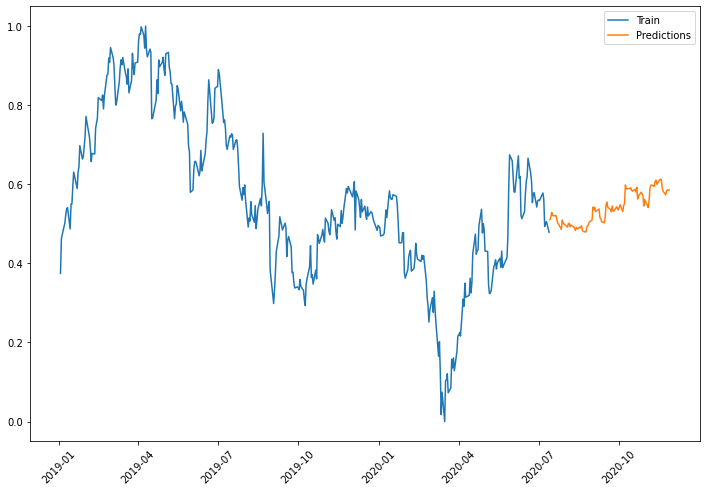

In [128]:
# plotting the predictions as an extension of the training data
plt.figure(figsize=(12,8))
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
plt.plot(data_with_sent.ALXN[:int(len(data_with_sent["ALXN"])*0.8)])
plt.plot(data_with_sent["pred"][int(len(data_with_sent["ALXN"])*0.8):])
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

<Figure size 864x576 with 0 Axes>

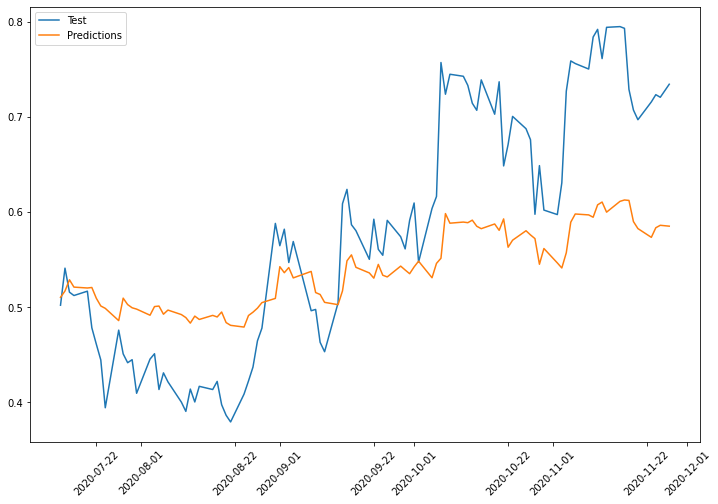

In [129]:
# plotting the predictions against the test data
plt.figure(figsize=(12,8))
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
plt.plot(y_test_sent)
plt.plot(data_with_sent["pred"][int(len(data_with_sent["ALXN"])*0.8):])
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [130]:
# checking the mean squared error
np.sqrt(np.mean(data_with_sent["pred"][int(len(data_with_sent["ALXN"])*0.8):] - y_test_sent)**2)

0.03812370072199698

# 3 Neural network for the articles with title text

In [152]:
# creating a sequential model
model = Sequential()
# adding the firstLSTM layer with 128 neurons, 0.2 dropout and recurrent dropout and return_sequences = True (to connect another LSTM layer)
model.add(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape = (61,100)))
# adding another LSTM layer - this time 64 neurons and no returning sequences
model.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# adding a dropout layer with 0.5 dropout rate
model.add(layers.Dropout(0.5))
# adding a dense layer with 128 neurons
model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dense(128, activation = "relu"))
# adding a dense layer with 64 neurons
model.add(layers.Dense(64, activation = "relu"))
# adding another dropout layer, this time just 0.2 dropout rate
model.add(layers.Dropout(0.2))
# adding the output layer with one neuron
model.add(layers.Dense(1))

In [153]:
# defining early stopping with the patience of 5 periods
stop = EarlyStopping(monitor = "loss", patience = 1, mode = "min", restore_best_weights=True)
# the same learning rate as for the first model - again caused by stability issues
opt = optimizers.Adam(learning_rate=0.0001)

In [154]:
# compiling the model
model.compile(loss='mean_squared_error', optimizer=opt)

In [155]:
# fitting the model to the data
history = model.fit(X_train_titl, y_train_titl, epochs=50, batch_size=1, verbose=1, callbacks = [stop])

Epoch 1/50
384/384 [==============================] - 71s 180ms/step - loss: 0.1989
Epoch 2/50
384/384 [==============================] - 66s 173ms/step - loss: 0.0546
Epoch 3/50
384/384 [==============================] - 68s 177ms/step - loss: 0.0492
Epoch 4/50
384/384 [==============================] - 67s 174ms/step - loss: 0.0524


In [156]:
# predicting the data
y_pred = model.predict(X_test_titl)

In [157]:
# filling a column with missing values
yf_df["pred"] = np.nan
# filling the column with the predictions
yf_df["pred"][int(len(yf_df["ALXN"])*0.8):] = np.array(y_pred).squeeze(1)

<Figure size 864x576 with 0 Axes>

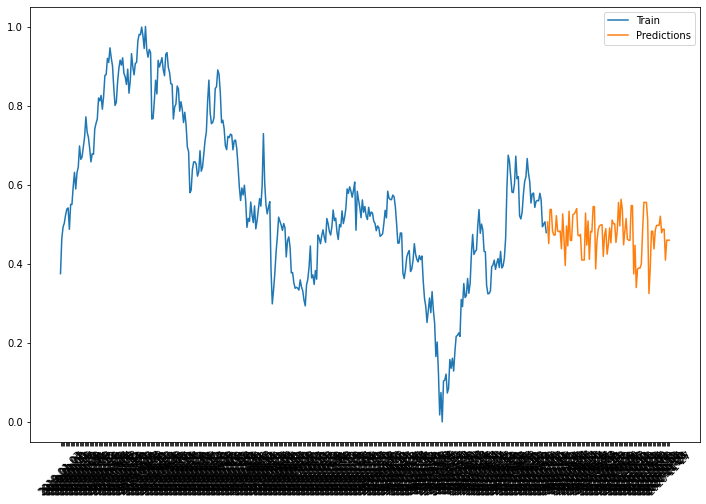

In [158]:
# plotting the predictions as an extension of the training data
plt.figure(figsize=(12,8))
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
plt.plot(yf_df.ALXN[:int(len(yf_df["ALXN"])*0.8)])
plt.plot(yf_df["pred"][int(len(yf_df["ALXN"])*0.8):])
plt.legend(['Train','Predictions'], loc='upper_center')
plt.show()

<Figure size 864x576 with 0 Axes>

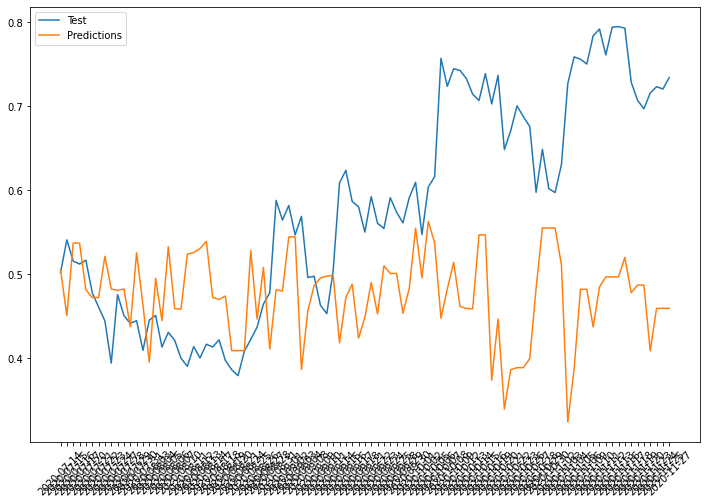

In [159]:
# plotting the predictions against the test data
plt.figure(figsize=(12,8))
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
plt.plot(y_test_titl)
plt.plot(yf_df["pred"][int(len(yf_df["ALXN"])*0.8):])
plt.legend(['Test','Predictions'], loc='upper_center')
plt.show()

In [160]:
# checking the mean squared error
np.sqrt(np.mean(yf_df["pred"][int(len(data_with_sent["ALXN"])*0.8):] - y_test_titl)**2)

0.10286076903836819